# IBM

### Imports

In [167]:
%load_ext autoreload 
%autoreload 2

%matplotlib inline

In [1]:
import plotly
plotly.tools.set_credentials_file(username='Jdemlow', api_key='k3hxWkf8FZGUdnr0Ig1F')
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.plotly as py
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from scipy.cluster import hierarchy as hc

from sklearn import metrics
from sklearn.metrics import f1_score, r2_score, recall_score

from pdpbox import pdp
from plotnine import *

from dfply import *
from ggplot import *

from imblearn.over_sampling import SMOTE

### Data

In [35]:
PATH = "data/HR/"

In [36]:
df_raw = pd.read_csv(f'{PATH}Employee-Attrition.csv', low_memory = True)

In [37]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000):
            display(df) 

In [38]:
df_raw.shape

(1470, 35)

In [39]:
df_raw.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

Looking at the data a set there is to much that showed me that the pay scaling was way off so the original data set will loose a couple of the pay matrix as they didn't make sense at all. There was no data dictionary to look at to allow us to better understand the synethic data created by the IBM Data Scientist


Really these data set is really flawed, but has so much goodness in it that I want to fix the pay issue and hours worked and they rest I will most likely just let it be. 

If an employee is allowed OT they are given a Yes and so with that we will use that as it seems pretty random. More notes on this will be below, but basically the idea is that we will be able to see how much money is being taken away from the dreaded "Salaried" positions. 

    -In the real world most companies aren't silly enough to ask their salaried positions to clock in because they would 
    realize that their effective rate compared to what their actual hourly rate is would make them cry a little bit 

### Creating A Better Pay Scale As The Current One Make No Sense At All

In [40]:
#Creating Realer Pay Scale and Hours Worked
pay = df_raw[['EmployeeNumber','OverTime', 'DailyRate','HourlyRate']]

In [41]:
pay.describe()

,EmployeeNumber,DailyRate,HourlyRate
count,1470.000000,1470.000000,1470.000000
mean,1024.865306,802.485714,65.891156
std,602.024335,403.509100,20.329428
min,1.000000,102.000000,30.000000
25%,491.250000,465.000000,48.000000
50%,1020.500000,802.000000,66.000000
75%,1555.750000,1157.000000,83.750000
max,2068.000000,1499.000000,100.000000


In [42]:
pay.dtypes

EmployeeNumber     int64
OverTime          object
DailyRate          int64
HourlyRate         int64
dtype: object

In [43]:
#Creates OT Hours worked
pay['OT_Hours'] = ((pay.DailyRate - (pay.HourlyRate * 8)) / (pay.HourlyRate*1.50));
pay.loc[(pay['OT_Hours'] <0), 'OT_Hours'] = 0;
pay['Daily_Hours'] = (pay.DailyRate / pay.HourlyRate);
pay.head()

,EmployeeNumber,OverTime,DailyRate,HourlyRate,OT_Hours,Daily_Hours
0,1,Yes,1102,94,2.482270,11.723404
1,2,No,279,61,0.000000,4.573770
2,4,Yes,1373,92,4.615942,14.923913
3,5,Yes,1392,56,11.238095,24.857143
4,7,No,591,40,4.516667,14.775000


In [44]:
#This might not be the best way of doing this, but this is how i figured out how to get number of hours worked
pay.loc[pay['OT_Hours'] > 0, 'Daily_Hours'] = pay.OT_Hours + 8

In [45]:
pay.head()

,EmployeeNumber,OverTime,DailyRate,HourlyRate,OT_Hours,Daily_Hours
0,1,Yes,1102,94,2.482270,10.482270
1,2,No,279,61,0.000000,4.573770
2,4,Yes,1373,92,4.615942,12.615942
3,5,Yes,1392,56,11.238095,19.238095
4,7,No,591,40,4.516667,12.516667


The idea is to use the Daily Rate that was given and the hourly rate of this employee

Let's look at the first example the employee is paid 94 dollars an hour meaning they should have a daily rate of 752 dollars a day, but this employee really was recieving 1,102 dollars a day. The Key to this is that Overtime is Yes for employee #1 meaning that the extra ~300 dollars is recieved compared to employee #7, which didn't recieve anything because they are salaried

    - Calculation is (DailyRate) - (hourlyRate * 8) / (hourlyRate *1.50) *Assumption that they are paid 1.50 after 8 hours*

In [46]:
#laughable that 361 employees are working 16+ hours come on now...
pay[(pay['Daily_Hours'] > 16)].shape

(281, 6)

In [47]:
#Lets just give them a .50% increase just thought that would be okay to try 
#NOTE THIS IS ONLY FOR EMPLOYEES WORKING 16 HOURS PLUS A DAY
pay.loc[pay.Daily_Hours > 16, 'HourlyRate'] = ((pay.HourlyRate) + (pay.HourlyRate * .50))

...... 281 employees are working more than 16 hours with less than 250 people leaving the company. This is laughable so this will be changed anyone working 18+ hours will see an increase in their hourly pay

In [48]:
#Creates OT Hours worked
pay['OT_Hours'] = (pay.DailyRate - (pay.HourlyRate * 8)) / (pay.HourlyRate*1.50);
pay.loc[(pay['OT_Hours'] <0), 'OT_Hours'] = 0;
pay['Daily_Hours'] = (pay.DailyRate / pay.HourlyRate)
pay.loc[pay['OT_Hours'] > 0, 'Daily_Hours'] = pay.OT_Hours + 8

In [49]:
#laughable that 361 employees are working 18+ hours come on now...
pay[(pay['Daily_Hours'] > 16)].shape

(84, 6)

In [50]:
#Lets just give them a .20% increase just thought that would be okay to try 
#NOTE THIS IS ONLY FOR EMPLOYEES WORKING 16 HOURS PLUS A DAY
pay.loc[pay.Daily_Hours > 16, 'HourlyRate'] = ((pay.HourlyRate) + (pay.HourlyRate * .20))
#Creates OT Hours worked
pay['OT_Hours'] = (pay.DailyRate - (pay.HourlyRate * 8)) / (pay.HourlyRate*1.50);
pay.loc[(pay['OT_Hours'] <0), 'OT_Hours'] = 0;
pay['Daily_Hours'] = (pay.DailyRate / pay.HourlyRate)
pay.loc[pay['OT_Hours'] > 0, 'Daily_Hours'] = pay.OT_Hours + 8
pay[(pay['Daily_Hours'] > 16)].shape

(44, 6)

In [51]:
#Okay this is a little better now lets look at the "non-salaried" 52 employees over 18 lets give another .50% increase 
pay[(pay['Daily_Hours'] > 16) & (pay['OverTime'] == 'Yes')].shape

(13, 6)

In [52]:
#Lets just give them a .20% increase just thought that would be okay to try 
#NOTE THIS IS ONLY FOR EMPLOYEES WORKING 16 HOURS PLUS A DAY
pay.loc[pay.Daily_Hours > 16, 'HourlyRate'] = ((pay.HourlyRate) + (pay.HourlyRate * .20))
#Creates OT Hours worked
pay['OT_Hours'] = (pay.DailyRate - (pay.HourlyRate * 8)) / (pay.HourlyRate*1.50);
pay.loc[(pay['OT_Hours'] <0), 'OT_Hours'] = 0;
pay['Daily_Hours'] = (pay.DailyRate / pay.HourlyRate)
pay.loc[pay['OT_Hours'] > 0, 'Daily_Hours'] = pay.OT_Hours + 8
pay[(pay['Daily_Hours'] > 16)].shape

(7, 6)

In [53]:
#Lets just give them a .10% increase just thought that would be okay to try 
#NOTE THIS IS ONLY FOR EMPLOYEES WORKING 16 HOURS PLUS A DAY
pay.loc[pay.Daily_Hours > 16, 'HourlyRate'] = ((pay.HourlyRate) + (pay.HourlyRate * .10))
#Creates OT Hours worked
pay['OT_Hours'] = (pay.DailyRate - (pay.HourlyRate * 8)) / (pay.HourlyRate*1.50);
pay.loc[(pay['OT_Hours'] <0), 'OT_Hours'] = 0;
pay['Daily_Hours'] = (pay.DailyRate / pay.HourlyRate)
pay.loc[pay['OT_Hours'] > 0, 'Daily_Hours'] = pay.OT_Hours + 8
pay[(pay['Daily_Hours'] > 16)].shape

(3, 6)

In [54]:
#Lets just give them a .10% increase just thought that would be okay to try 
#NOTE THIS IS ONLY FOR EMPLOYEES WORKING 16 HOURS PLUS A DAY
pay.loc[pay.Daily_Hours > 16, 'HourlyRate'] = ((pay.HourlyRate) + (pay.HourlyRate * .10))
#Creates OT Hours worked
pay['OT_Hours'] = (pay.DailyRate - (pay.HourlyRate * 8)) / (pay.HourlyRate*1.50);
pay.loc[(pay['OT_Hours'] <0), 'OT_Hours'] = 0;
pay['Daily_Hours'] = (pay.DailyRate / pay.HourlyRate)
pay.loc[pay['OT_Hours'] > 0, 'Daily_Hours'] = pay.OT_Hours + 8
pay[(pay['Daily_Hours'] > 16)].shape

(0, 6)

In [55]:
pay.HourlyRate.describe(),

df_raw.HourlyRate.describe(), 

(count    1470.000000
 mean       71.259929
 std        18.070045
 min        30.000000
 25%        58.000000
 50%        73.000000
 75%        85.875000
 max       106.500000
 Name: HourlyRate, dtype: float64, count    1470.000000
 mean       65.891156
 std        20.329428
 min        30.000000
 25%        48.000000
 50%        66.000000
 75%        83.750000
 max       100.000000
 Name: HourlyRate, dtype: float64)

In [159]:
df_raw.HourlyRate.describe(), 

(count    1470.000000
 mean       71.259929
 std        18.070045
 min        30.000000
 25%        58.000000
 50%        73.000000
 75%        85.875000
 max       106.500000
 Name: HourlyRate, dtype: float64,)

Even though I had to change a lot of hourly rates I did this with out know where the increases were going to be going to and which departments. I know this isn't the most sound way of doing something like this, but I couldn't think of a better way of doing this with the data making no sense from the original data set from IBM. It seems as thought IBM didn't think through hourly rates, Monthly Income, Monthly Rate as there isn't a correlation between them..... that makes zero sense. 

I am thankful for the data set, but IBM data scientist really should have thought that through a little bit more

In [56]:
pay.head()

,EmployeeNumber,OverTime,DailyRate,HourlyRate,OT_Hours,Daily_Hours
0,1,Yes,1102,94.0,2.482270,10.482270
1,2,No,279,61.0,0.000000,4.573770
2,4,Yes,1373,92.0,4.615942,12.615942
3,5,Yes,1392,84.0,5.714286,13.714286
4,7,No,591,40.0,4.516667,12.516667


In [57]:
pay['Weekly_OT'] = pay.OT_Hours * 5
pay['Bi_Weekly'] = pay.Daily_Hours*10

In [58]:
#It will be intersting to see where the OT is coming from as there is ~1Mil/Month 
#Could be ~12Mil allocated to other employees 
pay.Weekly_OT.sum()*76

1636902.5514211457

In [59]:
#Changing OT to 0 for salaried and daily rate of Salaried to 8 of actual pay 
pay.loc[pay.OverTime == "No", ["OT_Hours", "Weekly_OT"]] = 0;

In [60]:
pay['Monthly_Rate'] = (pay.HourlyRate*160);
pay['Effective_Rate'] = (pay.DailyRate / pay.Daily_Hours);

In [61]:
pay.head()

,EmployeeNumber,OverTime,DailyRate,HourlyRate,OT_Hours,Daily_Hours,Weekly_OT,Bi_Weekly,Monthly_Rate,Effective_Rate
0,1,Yes,1102,94.0,2.482270,10.482270,12.411348,104.822695,15040.0,105.129905
1,2,No,279,61.0,0.000000,4.573770,0.000000,45.737705,9760.0,61.000000
2,4,Yes,1373,92.0,4.615942,12.615942,23.079710,126.159420,14720.0,108.830557
3,5,Yes,1392,84.0,5.714286,13.714286,28.571429,137.142857,13440.0,101.500000
4,7,No,591,40.0,0.000000,12.516667,0.000000,125.166667,6400.0,47.217044


In [62]:
pay.loc[(pay['OT_Hours'] == 0) & (pay['Daily_Hours'] > 8), 'DailyRate'] = pay.HourlyRate * 8;
pay.loc[(pay['OT_Hours'] == 0) & (pay['Daily_Hours'] > 8), 'Effective_Rate'] = pay.DailyRate/ pay.Daily_Hours

In [69]:
pay.head()

,EmployeeNumber,OverTime,DailyRate,HourlyRate,OT_Hours,Daily_Hours,Weekly_OT,Bi_Weekly,Monthly_Rate,Effective_Rate,Monthly_Income,OT_Cost
0,1,Yes,1102.0,94.0,2.482270,10.482270,12.411348,104.822695,15040.0,105.129905,16820.784844,1780.784844
1,2,No,279.0,61.0,0.000000,4.573770,0.000000,45.737705,9760.0,61.000000,9760.000000,0.000000
2,4,Yes,1373.0,92.0,4.615942,12.615942,23.079710,126.159420,14720.0,108.830557,17412.889144,2692.889144
3,5,Yes,1392.0,84.0,5.714286,13.714286,28.571429,137.142857,13440.0,101.500000,16240.000000,2800.000000
4,7,No,320.0,40.0,0.000000,12.516667,0.000000,125.166667,6400.0,25.565912,4090.545939,-2309.454061


In [68]:
#pay.loc[(pay['OT_Hours'] > 0) & pay['Daily_Hours'] > 8, 'Effective_Rate'] = Hourly
pay['Monthly_Income'] = (pay.Effective_Rate *160) #also could have done DailyRate *20 for 20 workdays in a month;
pay['OT_Cost'] = (pay.Monthly_Income - pay.Monthly_Rate)

In [70]:
pay.loc[(pay['OT_Cost'] <0), 'OT_Cost'] = 0;

In [71]:
#Montly OT Cost OUCH!!! Granted the mean pay is 75 dollars an hours, but we will still take this as an issue 
pay.OT_Cost.sum()

524494.90838026139

In [72]:
pay.columns

Index(['EmployeeNumber', 'OverTime', 'DailyRate', 'HourlyRate', 'OT_Hours',
       'Daily_Hours', 'Weekly_OT', 'Bi_Weekly', 'Monthly_Rate',
       'Effective_Rate', 'Monthly_Income', 'OT_Cost'],
      dtype='object')

In [73]:
col = ['OT_Hours','Daily_Hours', 'Weekly_OT', 'Bi_Weekly', 'Effective_Rate',
       'Monthly_Rate', 'Monthly_Income', 'OT_Cost'] 

for c in col:
    pay[col] = round(pay[col],2)

In [74]:
pay.head()

,EmployeeNumber,OverTime,DailyRate,HourlyRate,OT_Hours,Daily_Hours,Weekly_OT,Bi_Weekly,Monthly_Rate,Effective_Rate,Monthly_Income,OT_Cost
0,1,Yes,1102.0,94.0,2.48,10.48,12.41,104.82,15040.0,105.13,16820.78,1780.78
1,2,No,279.0,61.0,0.00,4.57,0.00,45.74,9760.0,61.00,9760.00,0.00
2,4,Yes,1373.0,92.0,4.62,12.62,23.08,126.16,14720.0,108.83,17412.89,2692.89
3,5,Yes,1392.0,84.0,5.71,13.71,28.57,137.14,13440.0,101.50,16240.00,2800.00
4,7,No,320.0,40.0,0.00,12.52,0.00,125.17,6400.0,25.57,4090.55,0.00


### Merge pay With df_raw

In [75]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [76]:
col = ['OverTime', 'DailyRate', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate']
df_raw.drop(col, axis = 1, inplace = True)

In [77]:
df_raw = join_df(pay, df_raw, 'EmployeeNumber')

In [78]:
df_raw.loc[df_raw.Attrition == 'Yes', 'Attrition'] = 1
df_raw.loc[df_raw.Attrition == 'No', 'Attrition'] = 0

In [79]:
display_all(df_raw.head(3))

,EmployeeNumber,OverTime,DailyRate,HourlyRate,OT_Hours,Daily_Hours,Weekly_OT,Bi_Weekly,Monthly_Rate,Effective_Rate,Monthly_Income,OT_Cost,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,NumCompaniesWorked,Over18,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,Yes,1102.0,94.0,2.48,10.48,12.41,104.82,15040.0,105.13,16820.78,1780.78,41,1,Travel_Rarely,Sales,1,2,Life Sciences,1,2,Female,3,2,Sales Executive,4,Single,8,Y,11,3,1,80,0,8,0,1,6,4,0,5
1,2,No,279.0,61.0,0.00,4.57,0.00,45.74,9760.0,61.00,9760.00,0.00,49,0,Travel_Frequently,Research & Development,8,1,Life Sciences,1,3,Male,2,2,Research Scientist,2,Married,1,Y,23,4,4,80,1,10,3,3,10,7,1,7
2,4,Yes,1373.0,92.0,4.62,12.62,23.08,126.16,14720.0,108.83,17412.89,2692.89,37,1,Travel_Rarely,Research & Development,2,2,Other,1,4,Male,2,1,Laboratory Technician,3,Single,6,Y,15,3,2,80,0,7,3,3,0,0,0,0


In [83]:
train_cats(df_raw)

In [81]:
df_raw.EducationField.head()

0    Life Sciences
1    Life Sciences
2            Other
3    Life Sciences
4          Medical
Name: EducationField, dtype: category
Categories (6, object): [Human Resources < Life Sciences < Marketing < Medical < Other < Technical Degree]

In [82]:
df_raw.EducationField.cat.categories

Index(['Human Resources', 'Life Sciences', 'Marketing', 'Medical', 'Other',
       'Technical Degree'],
      dtype='object')

Something to think about is the Ordinal Structure of the data in this dataset will these need to ordered? 

For now I am going to leave them alone

In [84]:
#NO MISSING DATA 
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Age                         0.0
Attrition                   0.0
Bi_Weekly                   0.0
BusinessTravel              0.0
DailyRate                   0.0
Daily_Hours                 0.0
Department                  0.0
DistanceFromHome            0.0
Education                   0.0
EducationField              0.0
Effective_Rate              0.0
EmployeeCount               0.0
EmployeeNumber              0.0
EnvironmentSatisfaction     0.0
Gender                      0.0
HourlyRate                  0.0
JobInvolvement              0.0
JobLevel                    0.0
JobRole                     0.0
JobSatisfaction             0.0
MaritalStatus               0.0
Monthly_Income              0.0
Monthly_Rate                0.0
NumCompaniesWorked          0.0
OT_Cost                     0.0
OT_Hours                    0.0
Over18                      0.0
OverTime                    0.0
PercentSalaryHike           0.0
PerformanceRating           0.0
RelationshipSatisfaction    0.0
Standard

In [85]:
#Saving Data Set Created 
os.makedirs('tmp', exist_ok = True)
df_raw.to_feather('tmp/attrition-raw')

### Data Dictionary Incomplete At The Moment

In [86]:
df_raw.describe()

,EmployeeNumber,DailyRate,HourlyRate,OT_Hours,Daily_Hours,Weekly_OT,Bi_Weekly,Monthly_Rate,Effective_Rate,Monthly_Income,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,1024.865306,586.226999,71.259929,0.831048,9.972517,4.155469,99.725898,11401.588680,62.389041,9982.246639,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,602.024335,300.019838,18.070045,1.938263,3.996148,9.691832,39.961721,2891.207237,23.153467,3704.561250,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,1.000000,102.000000,30.000000,0.000000,1.180000,0.000000,11.820000,4800.000000,15.560000,2489.910000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,491.250000,376.000000,58.000000,0.000000,7.012500,0.000000,70.132500,9280.000000,42.735000,6836.990000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,1020.500000,552.000000,73.000000,0.000000,10.650000,0.000000,106.495000,11680.000000,60.545000,9687.415000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,1555.750000,712.000000,85.875000,0.000000,13.240000,0.000000,132.425000,13740.000000,82.000000,13120.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,2068.000000,1498.000000,106.500000,7.980000,16.000000,39.900000,160.000000,17040.000000,118.940000,19031.100000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


Age: The age of the employee 

Attrition: Did the employee leave? (Yes, No) 

Business Travel: 3 levels (Rare, Frequently, No Travel)

Distance From Home: Assumtion is going to be that these are in miles 1-28, which is much less than the average commute of a typical US employee 

DailyRate: How much an individual makes on the day in dollars

Department: Only three departments 

Education: 1-5 

Employee Count: Useless will drop

Employee Number: Unique identifier shouldn't be of interest as we know how long the employee has been with the company.

Envir Satisfaction: 1-4 

### EDA Through Model Inference 

I will be using a random forest and variable importance to allow myself to find out what might be the most important variables to look into more deeply

In [2]:
#With such a small data set this isn't really an issue, but its great practice for me to start using Feather Formats
df_raw = pd.read_feather('tmp/attrition-raw')

In [3]:
#Niave Rule Will Be .83 meaning we need to be able to predicted attrition better than 83 percent of the time
df_raw.Attrition.value_counts()/len(df_raw)

0    0.838776
1    0.161224
Name: Attrition, dtype: float64

In [4]:
df_trn, y_trn, nas =  proc_df(df_raw, 'Attrition')

#### Base Model

In [5]:
m = RandomForestClassifier(n_jobs= -1)
m.fit(df_trn, y_trn)
m.score(df_trn, y_trn)

0.98503401360544218

The Model maybe way over fitting, but it is good to know that it has the ability to accurately explain the variance 

### Partition

In [32]:
def split_vals(a, n): 
    return a[:n].copy(), a[n:].copy()

In [33]:
n_valid = int(len(df_raw)*.20)
n_trn = len(df_raw) - n_valid
raw_train, raw_valid= split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((1176, 40), (1176,), (294, 40))

In [34]:
y_train

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

### Base Model ROC .76

In [35]:
m = RandomForestClassifier(n_jobs= -1, oob_score=True)
%time m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5)),
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

Wall time: 120 ms
Training Acc: 0.97959
Validation Acc: 0.85714
Out-of-Bag Acc: 0.82908


In [36]:
y_predict = m.predict(X_valid)

In [37]:
score_test = metrics.f1_score(y_valid, y_predict, pos_label=list(set(y_valid)), average = None)

print(score_test)

[ 0.92164  0.19231]


In [38]:
probs = m.predict_proba(X_valid)
probs = [p[1] for p in probs]
fpr, tpr, thresholds = metrics.roc_curve(y_valid, probs)
roc_auc = metrics.roc_auc_score(y_valid, probs)

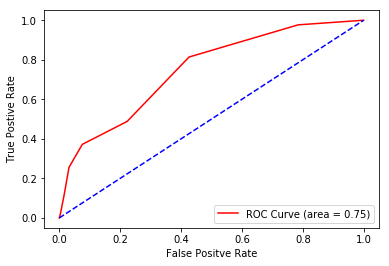

In [39]:
plt.plot(fpr, tpr, color = 'red', label = 'ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color = 'blue', linestyle = '--')
plt.legend(loc ="lower right")
plt.xlabel('False Positve Rate')
plt.ylabel('True Postive Rate')

First Model with all the defaults increases the accuracy by 3% so we can be happy about that, but we see a pretty extreme over fit here so far

### SMOTE To Oversample Due to Skewness In Target ROC = .78

In [40]:
oversampler = SMOTE(random_state=0, kind = 'svm')
smote_train, smote_target = oversampler.fit_sample(X_train, y_train)

In [41]:
m = RandomForestClassifier(n_jobs= -1, n_estimators=150, oob_score=True, max_features=.8, min_samples_leaf=10)
%time m.fit(smote_train, smote_target)
print("Training Acc:", round(m.score(smote_train, smote_target),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5)),
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

Wall time: 1.38 s
Training Acc: 0.93381
Validation Acc: 0.88776
Out-of-Bag Acc: 0.89817


In [42]:
y_predict = m.predict(X_valid)

In [43]:
score_test = metrics.f1_score(y_valid, y_predict, pos_label=list(set(y_valid)), average = None)

print(score_test)

[ 0.93567  0.56   ]


In [44]:
probs = m.predict_proba(X_valid)
probs = [p[1] for p in probs]
fpr, tpr, thresholds = metrics.roc_curve(y_valid, probs)
roc_auc = metrics.roc_auc_score(y_valid, probs)

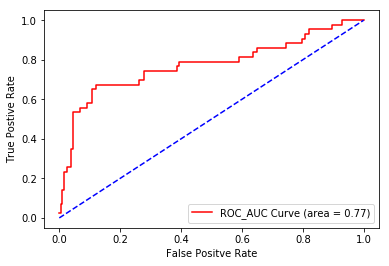

In [45]:
plt.plot(fpr, tpr, color = 'red', label = 'ROC_AUC Curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color = 'blue', linestyle = '--')
plt.legend(loc ="lower right")
plt.xlabel('False Positve Rate')
plt.ylabel('True Postive Rate')

### Tree Features 

SMOTE will be looked into more as the modeling becomes strong, but I am going to go with more of the default for now to see what is driving attrition at this company

In [46]:
m = RandomForestClassifier(n_jobs= -1, n_estimators=20, oob_score=True)
%time m.fit(smote_train, smote_target)
print("Training Acc:", round(m.score(smote_train, smote_target),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5))
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

Wall time: 131 ms
Training Acc: 1.0
Validation Acc: 0.86395
Out-of-Bag Acc: 0.89766


In [47]:
m = RandomForestClassifier(n_jobs= -1, n_estimators=40, oob_score=True)
%time m.fit(smote_train, smote_target)
print("Training Acc:", round(m.score(smote_train, smote_target),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5))
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

Wall time: 159 ms
Training Acc: 1.0
Validation Acc: 0.86054
Out-of-Bag Acc: 0.91242


In [48]:
m = RandomForestClassifier(n_jobs= -1, n_estimators=100, oob_score=True)
%time m.fit(smote_train, smote_target)
print("Training Acc:", round(m.score(smote_train, smote_target),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5))
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

Wall time: 374 ms
Training Acc: 1.0
Validation Acc: 0.88095
Out-of-Bag Acc: 0.92261


#### Cross Validation Grid Search Doesn't Work Well Again

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
param_grid = {
    'min_samples_leaf' :[1,3,5], 
    'max_features' : [10,15,20,.6,.5,.8, 'sqrt', 'log2'],
    #'criterion' : ['accuracy', 'precision', '']
}

In [51]:
cvRF = GridSearchCV(estimator=m, param_grid=param_grid, cv=3, scoring='recall')
%time cvRF.fit(smote_train, smote_target)

Wall time: 45.4 s


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 3, 5], 'max_features': [10, 15, 20, 0.6, 0.5, 0.8, 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [52]:
cvRF.best_params_

{'max_features': 15, 'min_samples_leaf': 1}

In [53]:
cvRF.best_score_

0.86965376782077397

### Tree Parameters Adjusted Cont..

In [54]:
m = RandomForestClassifier(n_jobs= -1, n_estimators=150, oob_score=True, max_features=.8, min_samples_leaf=10)
%time m.fit(smote_train, smote_target)
print("Training Acc:", round(m.score(smote_train, smote_target),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5)),
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

Wall time: 1.2 s
Training Acc: 0.93228
Validation Acc: 0.88095
Out-of-Bag Acc: 0.89664


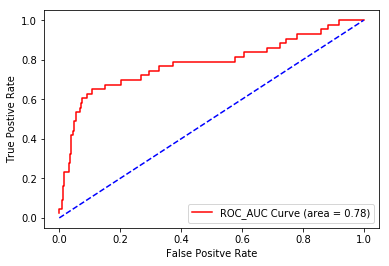

In [55]:
probs = m.predict_proba(X_valid)
probs = [p[1] for p in probs]
fpr, tpr, thresholds = metrics.roc_curve(y_valid, probs)
roc_auc = metrics.roc_auc_score(y_valid, probs)
plt.plot(fpr, tpr, color = 'red', label = 'ROC_AUC Curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color = 'blue', linestyle = '--')
plt.legend(loc ="lower right")
plt.xlabel('False Positve Rate')
plt.ylabel('True Postive Rate')

### Feature Importance

In [56]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
1,OverTime,0.354239
22,JobLevel,0.096364
32,StockOptionLevel,0.081203
21,JobInvolvement,0.047786
19,EnvironmentSatisfaction,0.043094
14,Department,0.028839
4,OT_Hours,0.028168
33,TotalWorkingYears,0.022036
16,Education,0.021730
26,NumCompaniesWorked,0.020995


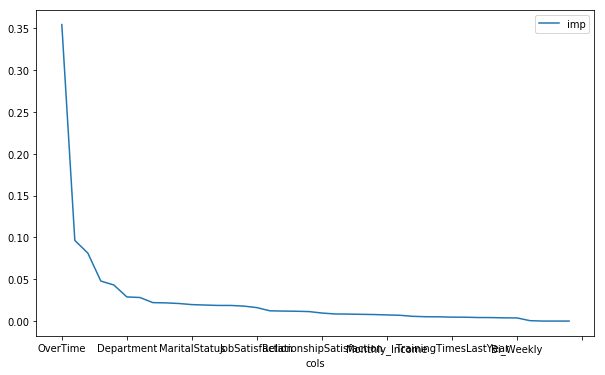

In [57]:
fi.plot('cols', 'imp', figsize=(10,6), legend=True);

In [58]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

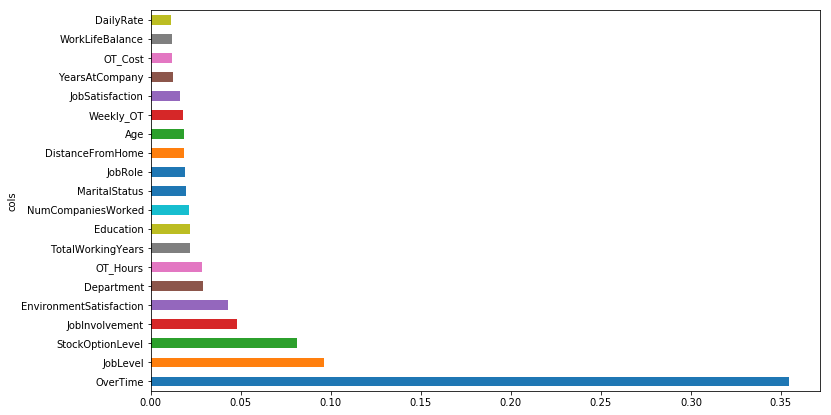

In [59]:
plot_fi(fi[:20]);

In [60]:
#looking 
to_keep = fi[fi.imp > 0.005].cols; len(to_keep)

30

In [61]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [71]:
m = RandomForestClassifier(n_jobs= -1, n_estimators=250, oob_score=True, max_features=.8, min_samples_leaf=3)
%time m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5))
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

Wall time: 992 ms
Training Acc: 0.96514
Validation Acc: 0.87755
Out-of-Bag Acc: 0.84694


In [72]:
from scipy.cluster import hierarchy as hc

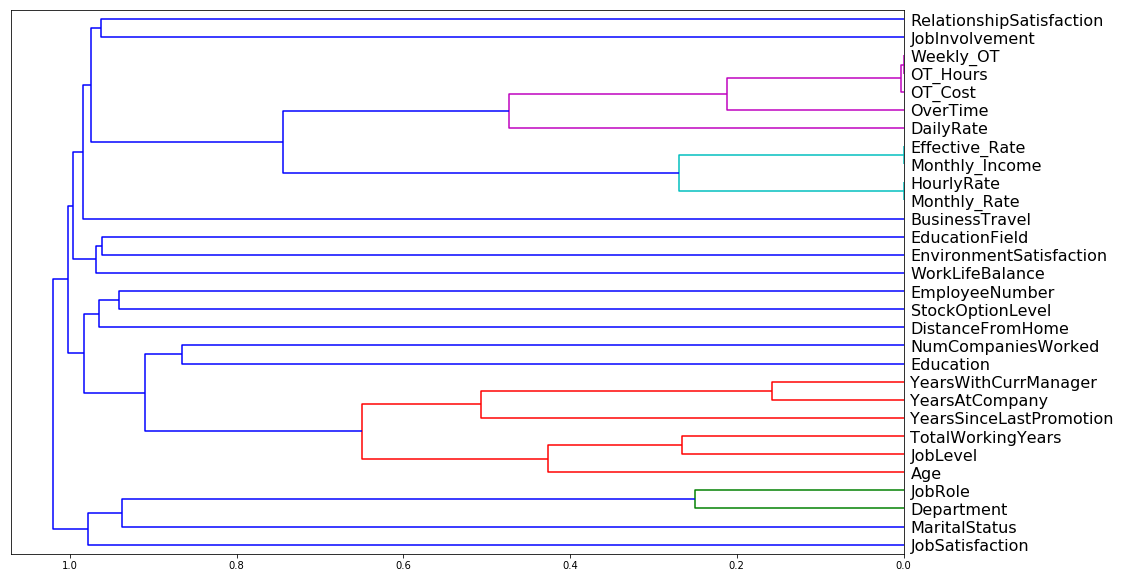

In [73]:
#using the corelation spearman rank correlation
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [74]:
def get_oob(df):
    m = RandomForestClassifier(n_jobs= -1, n_estimators=350, oob_score=True, max_features=.8, min_samples_leaf=5)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [75]:
get_oob(df_keep)

0.84353741496598644

In [76]:
df_keep.columns

Index(['OverTime', 'JobLevel', 'StockOptionLevel', 'JobInvolvement',
       'EnvironmentSatisfaction', 'Department', 'OT_Hours',
       'TotalWorkingYears', 'Education', 'NumCompaniesWorked', 'MaritalStatus',
       'JobRole', 'DistanceFromHome', 'Age', 'Weekly_OT', 'JobSatisfaction',
       'YearsAtCompany', 'OT_Cost', 'WorkLifeBalance', 'DailyRate',
       'RelationshipSatisfaction', 'EducationField', 'EmployeeNumber',
       'BusinessTravel', 'YearsWithCurrManager', 'Monthly_Income',
       'Effective_Rate', 'YearsSinceLastPromotion', 'Monthly_Rate',
       'HourlyRate'],
      dtype='object')

In [77]:
for c in ('Weekly_OT','OT_Cost','OT_Hours','Monthly_Income','Effective_Rate','EmployeeNumber'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

Weekly_OT 0.84693877551
OT_Cost 0.848639455782
OT_Hours 0.84693877551
Monthly_Income 0.847789115646
Effective_Rate 0.84693877551
EmployeeNumber 0.849489795918


In [78]:
to_drop = ['OT_Cost','OT_Hours','Monthly_Income','EmployeeNumber']
get_oob(df_keep.drop(to_drop, axis=1))

0.84863945578231292

In [79]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

In [80]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [81]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

In [82]:
m = RandomForestClassifier(n_jobs= -1, n_estimators=350, oob_score=True, max_features=.8, min_samples_leaf=5)
%time m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5))
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

Wall time: 1.08 s
Training Acc: 0.92432
Validation Acc: 0.87415
Out-of-Bag Acc: 0.84694


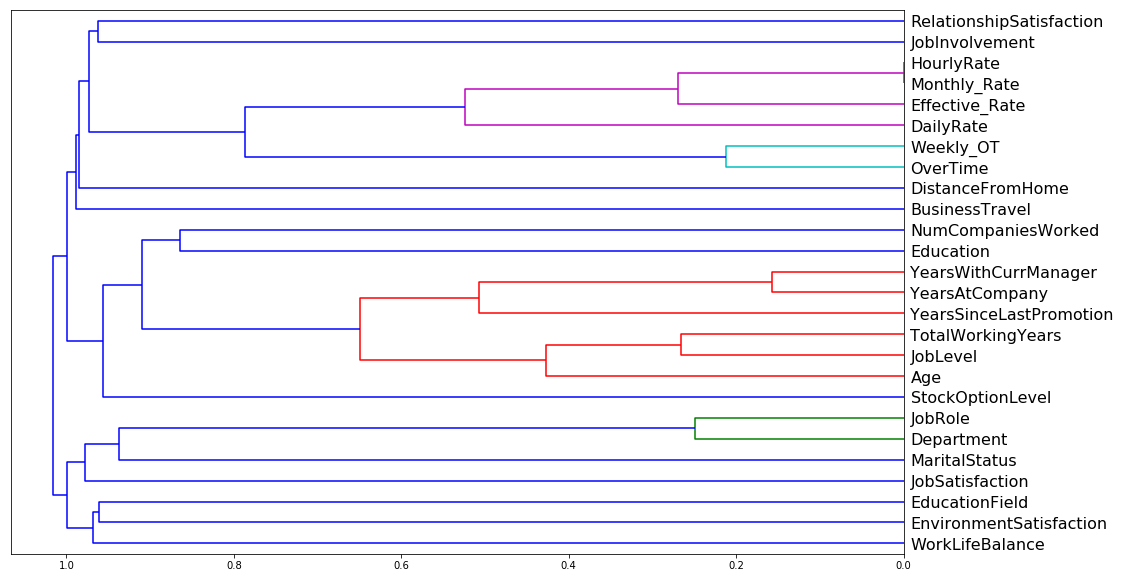

In [83]:
#using the corelation spearman rank correlation
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [86]:
for c in ('HourlyRate', 'Monthly_Rate', 'Effective_Rate', 'DailyRate', 'Weekly_OT', 'OverTime'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

HourlyRate 0.850340136054
Monthly_Rate 0.847789115646
Effective_Rate 0.845238095238
DailyRate 0.849489795918
Weekly_OT 0.846088435374
OverTime 0.840136054422


In [87]:
to_drop = ['HourlyRate', 'Monthly_Rate', 'DailyRate','Weekly_OT']
get_oob(df_keep.drop(to_drop, axis=1))

0.84778911564625847

In [88]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

In [89]:
m = RandomForestClassifier(n_jobs= -1, n_estimators=350, oob_score=True, max_features=.8, min_samples_leaf=5)
%time m.fit(X_train, y_train)
print("Training Acc:", round(m.score(X_train, y_train),5)),
print("Validation Acc:", round(m.score(X_valid, y_valid), 5))
print("Out-of-Bag Acc:", round(m.oob_score_, 5))

Wall time: 890 ms
Training Acc: 0.92007
Validation Acc: 0.87755
Out-of-Bag Acc: 0.84949


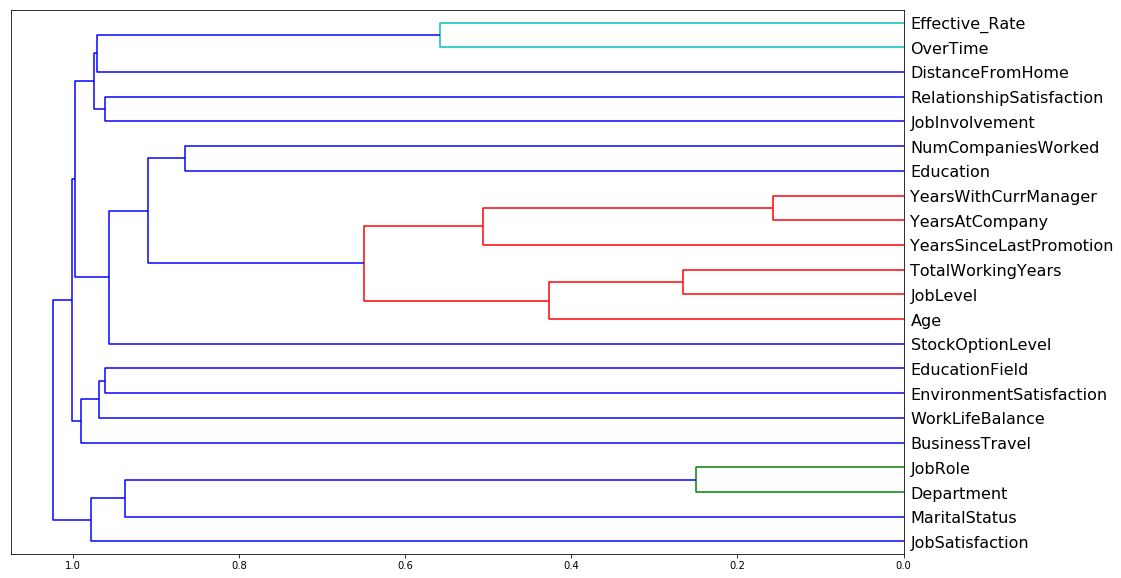

In [90]:
#using the corelation spearman rank correlation
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

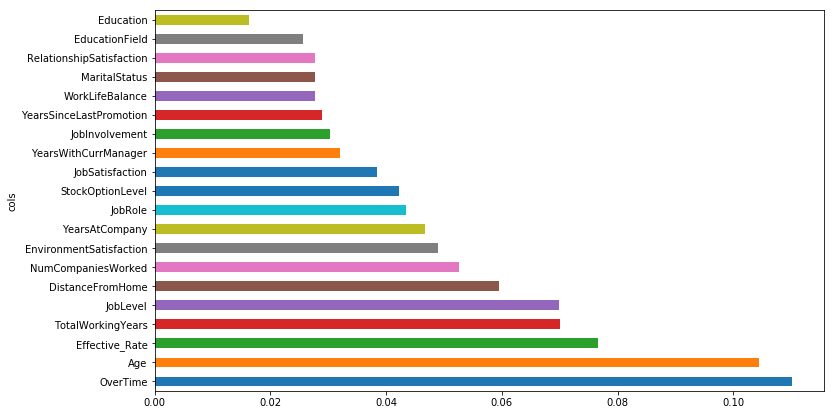

In [91]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:20]);

### EDA

In [92]:
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set_palette("husl")

**Attrition**

We know there is an imbalance in this variable and it is futher seen below

### Plot 1

This is the first plot because this was the largest and most obvious distinction between the employees that have left our company and the employees that are still with the company. You may think that this is an obvious trend, but there is a story to be told from the plots below. 

1. Our lower level employees are leaving at an alarming rate and even though these might be low skill level jobs not having employees doing this type of work can cripple and organization. 

2. We see that upper management is over happy with the jobs they are given as the attrition rate is low, but for those with a level 5 job tend to leave more proportional to the level 4 jobs. 

3. Are mid-level management seems to be split 50/50 meaning that the talent that is groomed to take over a level 4 or level 5 jobs are leaving at a rate of a coin toss.

4. Looking at the pdp plot of this chart below there is slight evidence that the there is an upward trend as you move up the latter from 2 -> 3 -> 4 -> 5 of the job level. There is a very slight increase meaning that just giving an employee a different amount of responsibilities will not alleviate the chance of attrition even though it does help a little.

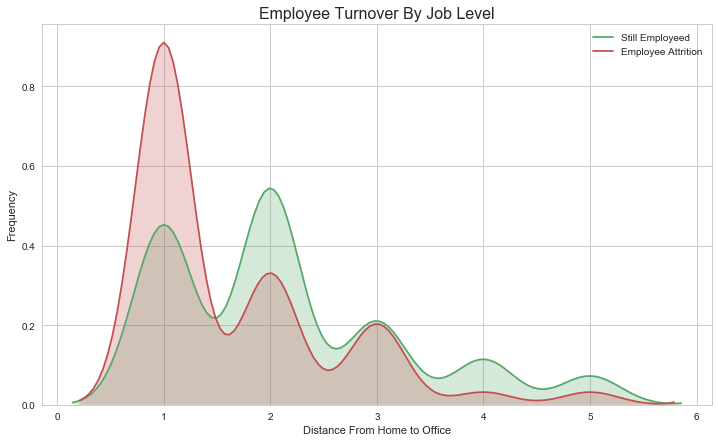

In [165]:
plt.figure(figsize=(12,7))
ax=sns.kdeplot(df_raw.loc[(df_raw.Attrition==0),'JobLevel'],color="g",shade=True,label="Still Employeed")
ax=sns.kdeplot(df_raw.loc[(df_raw.Attrition==1),'JobLevel'],color="r",shade=True,label="Employee Attrition")
ax.set(xlabel='Distance From Home to Office',ylabel="Frequency")
plt.title("Employee Turnover By Job Level",fontsize=16)

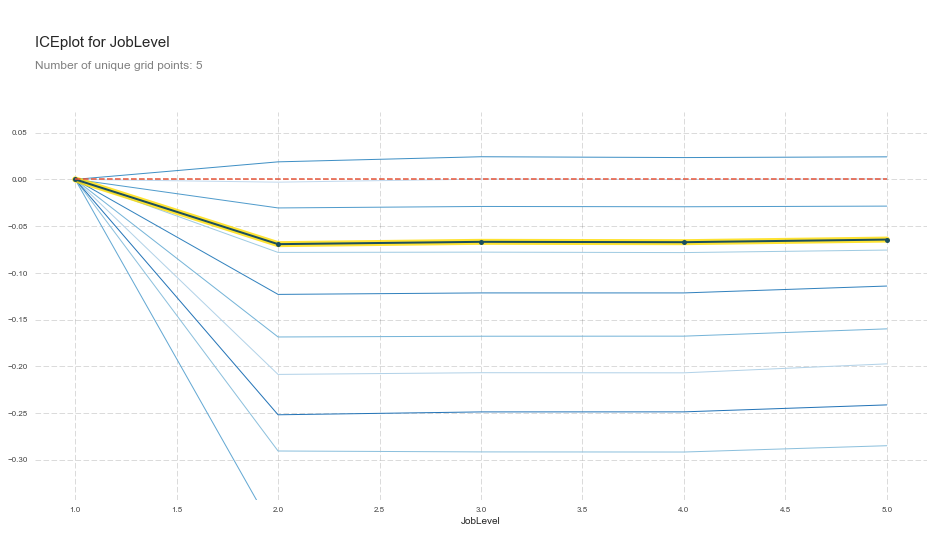

In [166]:
plot_pdp('JobLevel', clusters = 10)

### Plot 2

Individuals that live farther away from their work place tend to look for a job closer to where they live as moving a family is quite expensive. In this company this trend is relevant as well and after about 10 mile radius from the home office is when there begins to be an increase in attrition. This is seen in both charts below and for every additional 5-8 miles of commute there is an increased chance of leaving the company. 

1. What and a company do about this?
    
    a. This company and look to reimburse mileage or investigate giving a certain group of employee’s company cars if the company see that a certain role or department is where the long commuters are coming from. 
    
    b. The company can implement recruiting closer to home and help new hires find homes or places to rent allowing this issue of commuting to be mitigated.


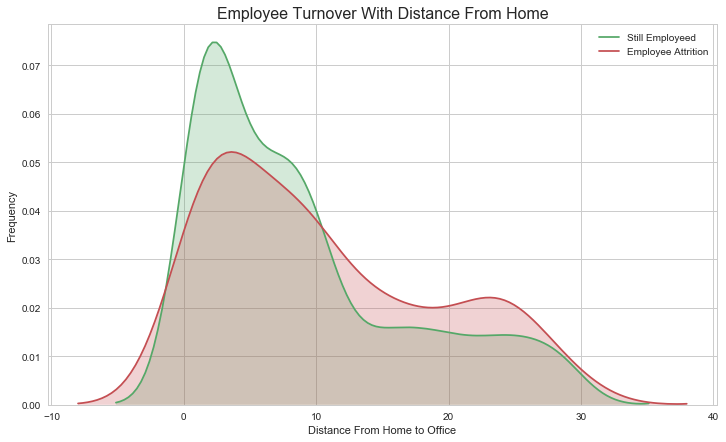

In [168]:
plt.figure(figsize=(12,7))
ax=sns.kdeplot(df_raw.loc[(df_raw.Attrition==0),'DistanceFromHome'],color="g",shade=True,label="Still Employeed")
ax=sns.kdeplot(df_raw.loc[(df_raw.Attrition==1),'DistanceFromHome'],color="r",shade=True,label="Employee Attrition")
ax.set(xlabel='Distance From Home to Office',ylabel="Frequency")
plt.title("Employee Turnover With Distance From Home",fontsize=16)

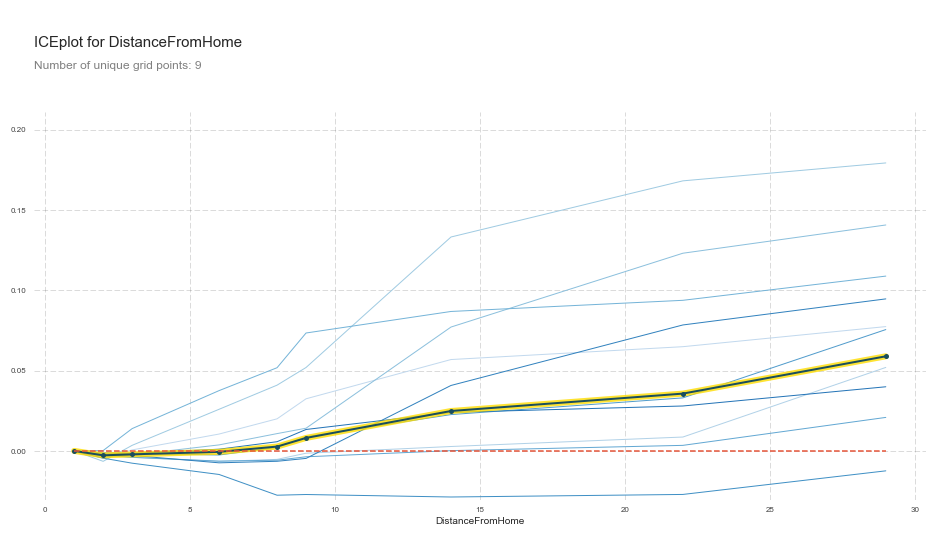

In [169]:
plot_pdp('DistanceFromHome', clusters = 10)

#### Target Variable

In [93]:
data = [go.Bar(
x = df_raw["Attrition"].value_counts().index.values, 
y = df_raw["Attrition"].value_counts().values, 
text = "Distribution of Target Variable")]

layout = go.Layout(title = "Target Variable Distribution")

fig = go.Figure(data = data, layout= layout)

py.iplot(fig, filename = 'basic-bar')

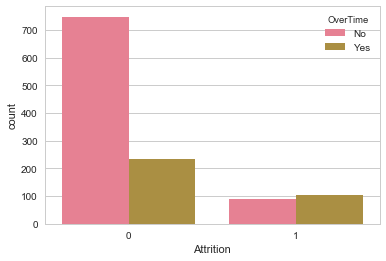

In [157]:
sns.countplot(x="Attrition", hue="OverTime", data=raw_train)

#### OverTime

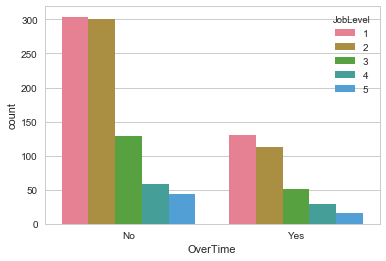

In [141]:
sns.countplot(x="OverTime", hue="JobLevel", data=raw_train)

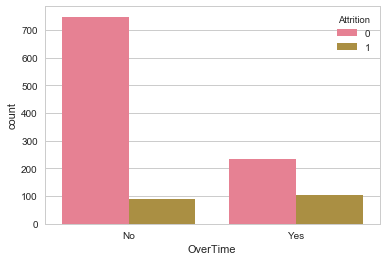

In [142]:
sns.countplot(x="OverTime", hue="Attrition", data=raw_train)

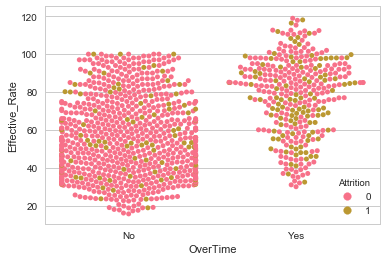

In [152]:
sns.swarmplot(x="OverTime", y="Effective_Rate", hue = "Attrition", data=raw_train);

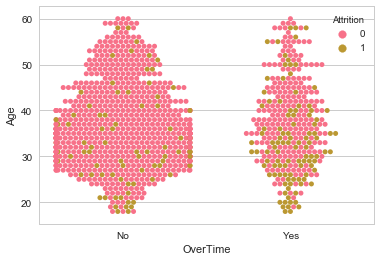

In [156]:
sns.swarmplot(x="OverTime", y="Age",hue = "Attrition", data=raw_train);

Even Though Daily Hours didn't make it according the the RDF I wanted to look to see if this company paying people with less hours more Overtime, but the plots seem to suggest that they don't. 

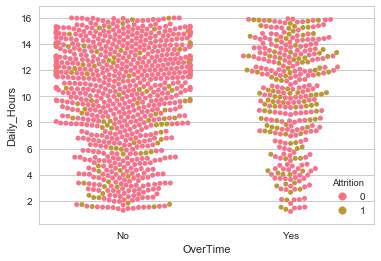

In [153]:
sns.swarmplot(x="OverTime", y="Daily_Hours",hue = "Attrition", data=raw_train);

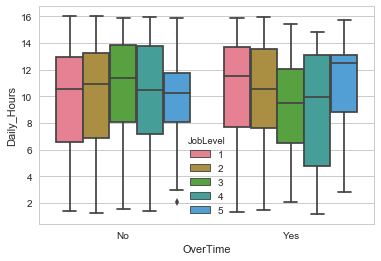

In [155]:
sns.boxplot(x="OverTime", y="Daily_Hours", hue="JobLevel", data=raw_train);

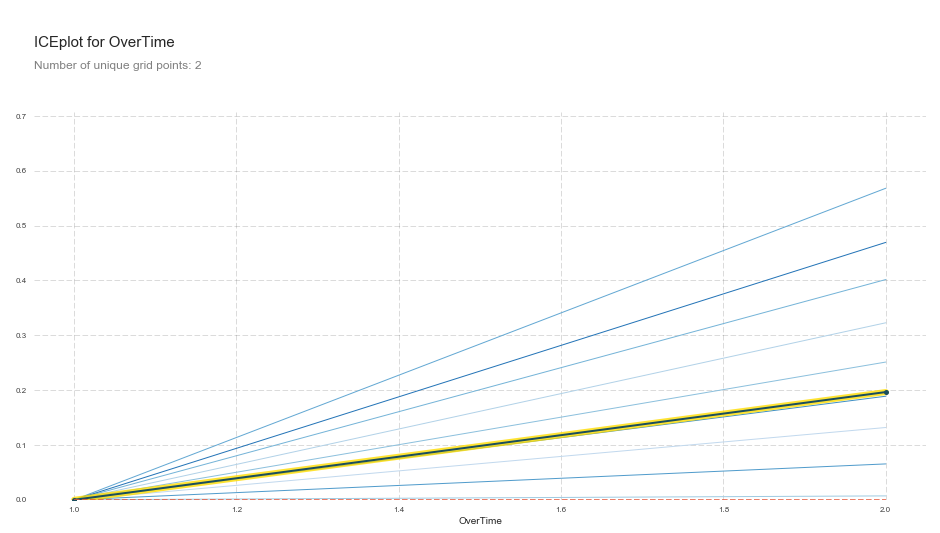

In [158]:
plot_pdp('OverTime', clusters=10)

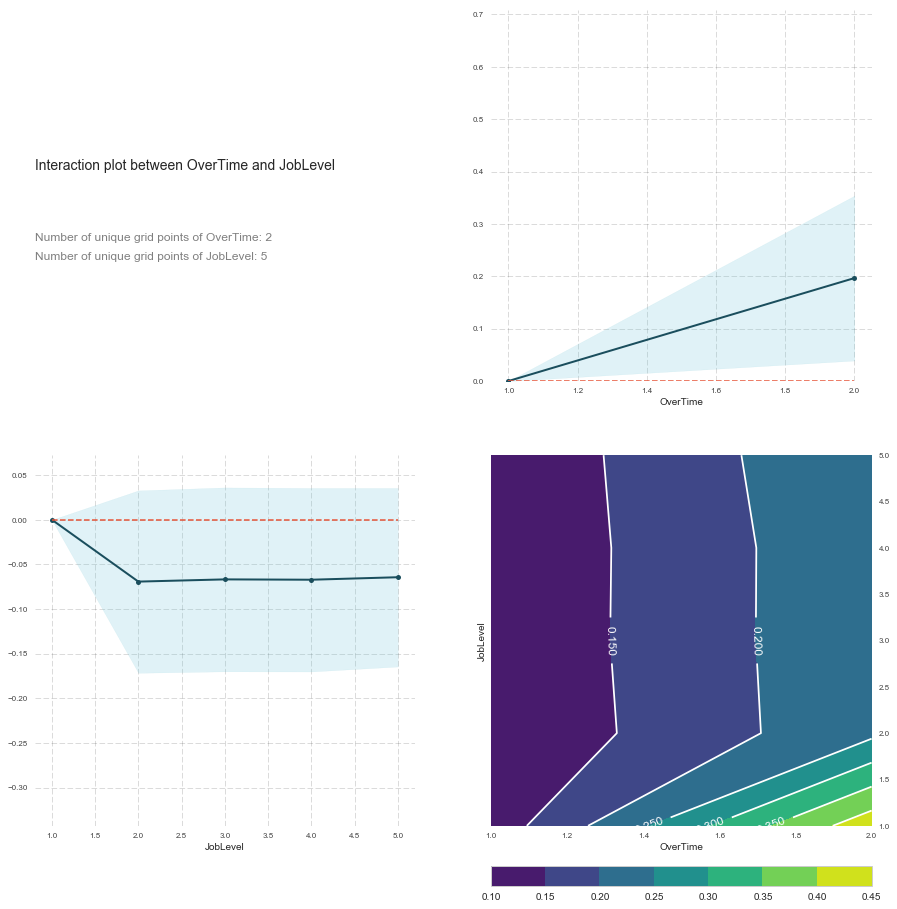

In [164]:
feats = ['OverTime', 'JobLevel']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

#### Age 

**AGE** 

Interestingly this is the most important variable and after thinking awhile I believe that ther emight be some redundancy with Age and Total Working Years so I may need to remove Total Working Years, but this will be examined further in a moment 

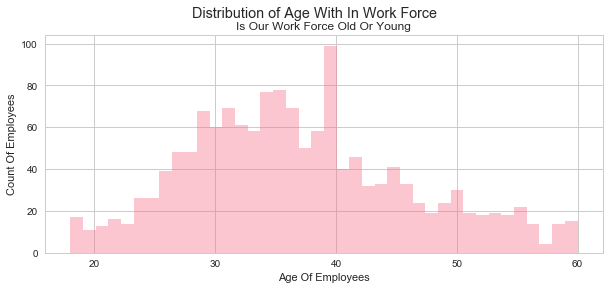

In [94]:
plt.figure(figsize=(10, 4))
sns.distplot(df_raw.Age, bins = 40, kde = False) 
plt.suptitle("Distribution of Age With In Work Force")
plt.title("Is Our Work Force Old Or Young")
plt.ylabel("Count Of Employees")
plt.xlabel("Age Of Employees")
plt.show()

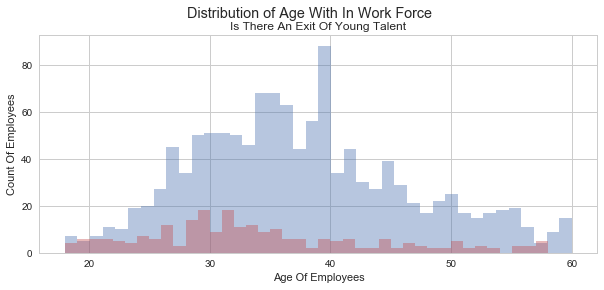

In [95]:
plt.figure(figsize=(10, 4))
sns.distplot(df_raw.loc[(df_raw.Attrition == 0), 'Age'], color = "b", label = "Employeed", bins = 40, kde = False) 
sns.distplot(df_raw.loc[(df_raw.Attrition == 1), 'Age'], color = "r", label = "Left Company", bins = 40, kde = False) 
plt.suptitle("Distribution of Age With In Work Force")
plt.title("Is There An Exit Of Young Talent")
plt.ylabel("Count Of Employees")
plt.xlabel("Age Of Employees")
plt.show()

There seems to be an exit of employees in the range of 18-25 these are the employees of the future and also it looks like we have a spike in mid career exits with this company further investigation will need to be looked at

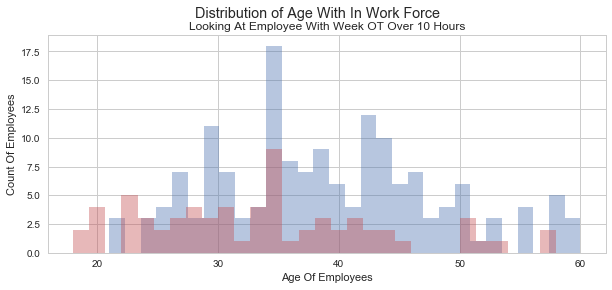

In [96]:
plt.figure(figsize=(10, 4))
sns.distplot(df_raw.loc[(df_raw.Attrition == 0) & (df_raw.Weekly_OT > 10), 'Age'], color = "b", label = "Employeed", bins = 30, kde = False) 
sns.distplot(df_raw.loc[(df_raw.Attrition == 1) & (df_raw.Weekly_OT > 10), 'Age'], color = "r", label = "Employeed", bins = 30, kde = False) 
plt.suptitle("Distribution of Age With In Work Force")
plt.title("Looking At Employee With Week OT Over 10 Hours")
plt.ylabel("Count Of Employees")
plt.xlabel("Age Of Employees")
plt.show()

Something I am interested in is do employee leave when they have more hours than 8 and don't get paid for it because they are Salaried Employees 
Vs. 
Employees who get paid to be there for the extra hours. 

There are 1054 employee that are "Salaried" Employees of those Salaried Employees 110 of them left the company and 70 of them were working more than 8 hours a day leading to suggest this could be why the left. The next chart will have 730 employees that meet the "Salaried" & working over 8 hours a day.

Lets just see if age is something that has to do with Attritition as the old individuals will most likely be okay with this as this was a part of the culture as they grew up, but the new "milienal" ideals lead to living a life that a jobs supports not the other way around. (There is much to be said about both ideals and the perfect medium is a little bit of both)

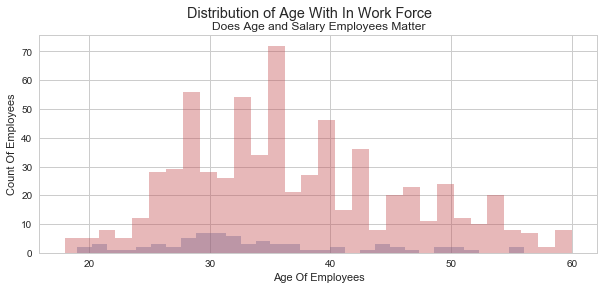

In [97]:
plt.figure(figsize=(10, 4))
sns.distplot(df_raw.loc[(df_raw.Attrition == 1) & (df_raw.OverTime == 'No') & (df_raw.Daily_Hours > 8), 'Age'], color = "b", label = "Employeed", bins = 30, kde = False) 
sns.distplot(df_raw.loc[(df_raw.Attrition == 0) & (df_raw.OverTime == 'No') & (df_raw.Daily_Hours > 8), 'Age'], color = "r", label = "Employeed", bins = 30, kde = False) 
plt.suptitle("Distribution of Age With In Work Force")
plt.title("Does Age and Salary Employees Matter")
plt.ylabel("Count Of Employees")
plt.xlabel("Age Of Employees")
plt.show()

In [ ]:
x = get_sample(X_train, 500)

In [101]:
from pdpbox import pdp
from plotnine import *
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

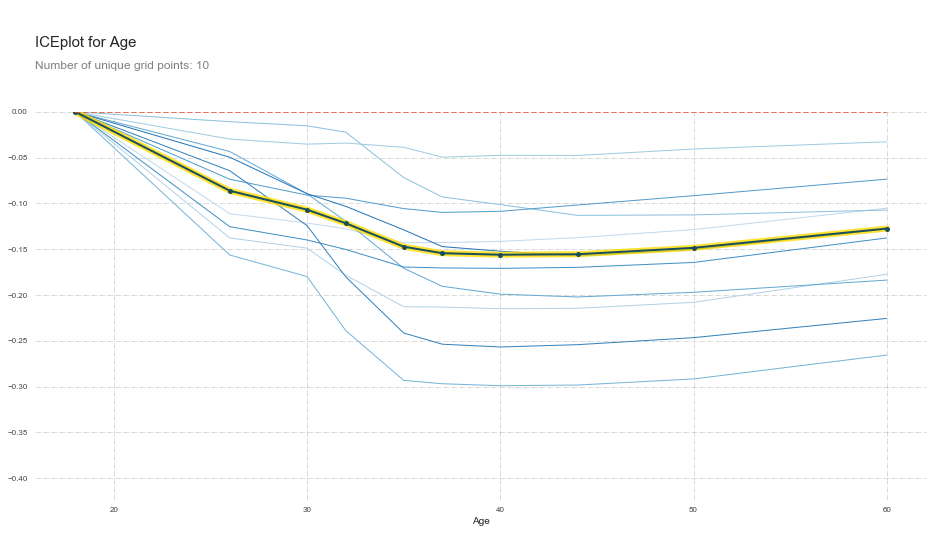

In [121]:
plot_pdp('Age', clusters=10)

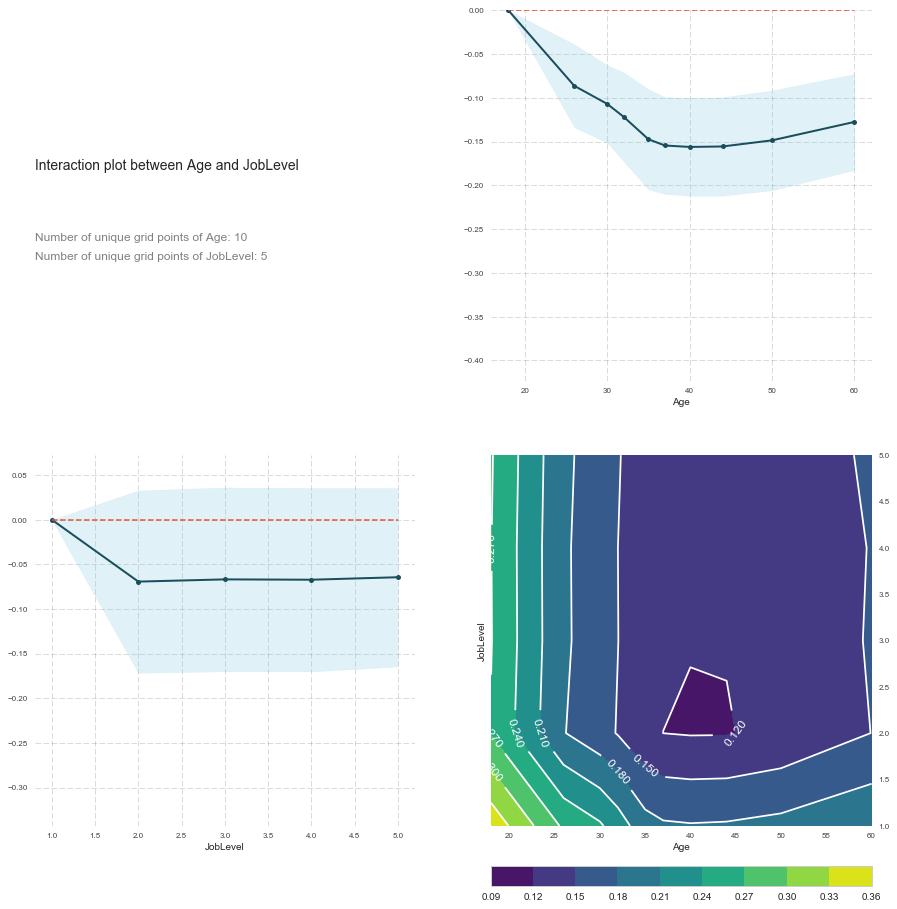

In [122]:
feats = ['Age', 'JobLevel']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

#### Effective Rate

This is probably a strong indicator because this is Rate really shows if you're allowed to be paid for all the hours that you work or if you are working for "free" or in turn decreasing your "Actual" hourly rate.

i.e if you work 8 hours for 10 dollars an hour you get 80 dollars 

    if you work 10 hours for 10 dollars an hour and are salaried you get 80 dollars, but your effective rate is now 8 dollars in hours. 
    
    if you work 10 hours for 10 dollars an hour and aren't salaried then you get paid 80 dollars plus 15 an hour for the extra two hours worked meaning you get paid a 110 dollars an hour. Making you effective rate 13.75, which is an impressive spike and this is even more when making more dollars an hour. With Taxes though a lot of it isn't seen :(
    
(Note doing EDA I realized I needed not only to make the effective rate for individuals who get paid more, but also this situation. I will be interested to see if this makes a difference later on. ). 

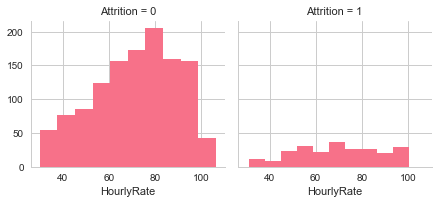

In [110]:
g = sns.FacetGrid(df_raw, col = 'Attrition', col_wrap= 4)
g.map(plt.hist, "HourlyRate")

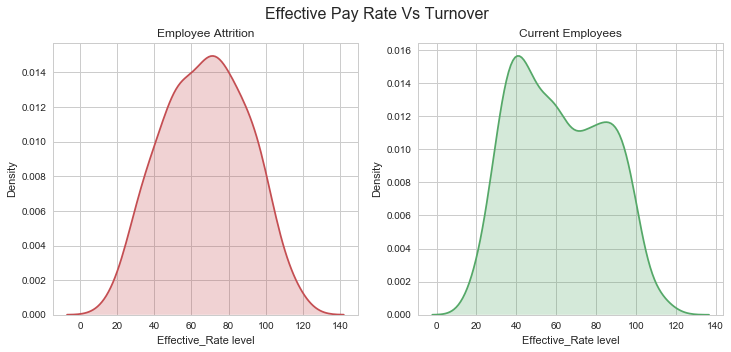

In [109]:
fig,ax=plt.subplots(ncols=2,figsize=(12,5))
left = df_raw[df_raw.Attrition == 1] 
stay = df_raw[df_raw.Attrition == 0]
sns.kdeplot(left.Effective_Rate, shade = True, color = "r", ax=ax[0],legend=False)
ax[0].set_xlabel("Effective_Rate level")
ax[0].set_ylabel("Density")
ax[0].set_title("Employee Attrition")
sns.kdeplot(stay.Effective_Rate, shade = True, color = "g", ax=ax[1],legend=False)
ax[1].set_xlabel("Effective_Rate level")
ax[1].set_ylabel("Density")
ax[1].set_title("Current Employees")
plt.suptitle("Effective Pay Rate Vs Turnover",fontsize=16)

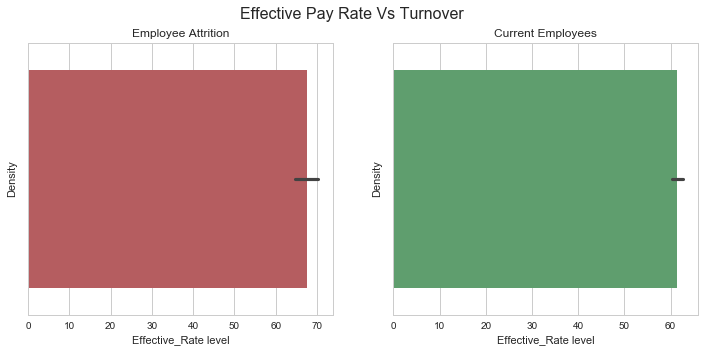

In [108]:
fig,ax=plt.subplots(ncols=2,figsize=(12,5))
left = df_raw[df_raw.Attrition == 1] 
stay = df_raw[df_raw.Attrition == 0]
sns.barplot(left.Effective_Rate, color = "r", ax=ax[0])
ax[0].set_xlabel("Effective_Rate level")
ax[0].set_ylabel("Density")
ax[0].set_title("Employee Attrition")
sns.barplot(stay.Effective_Rate,  color = "g", ax=ax[1])
ax[1].set_xlabel("Effective_Rate level")
ax[1].set_ylabel("Density")
ax[1].set_title("Current Employees")
plt.suptitle("Effective Pay Rate Vs Turnover",fontsize=16)

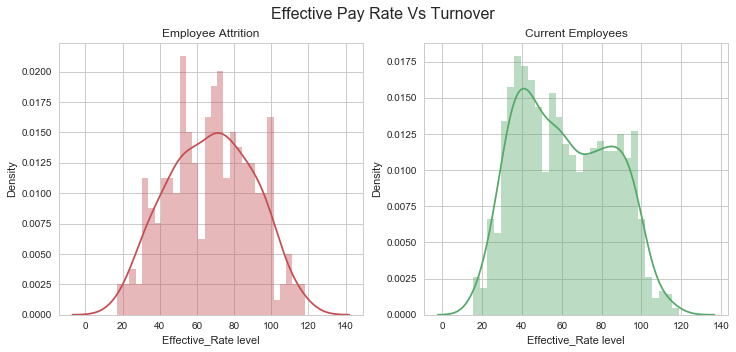

In [111]:
fig,ax=plt.subplots(ncols=2,figsize=(12,5))
left = df_raw[df_raw.Attrition == 1] 
stay = df_raw[df_raw.Attrition == 0]
sns.distplot(left.Effective_Rate, color = "r", bins = 30, ax=ax[0])
ax[0].set_xlabel("Effective_Rate level")
ax[0].set_ylabel("Density")
ax[0].set_title("Employee Attrition")
sns.distplot(stay.Effective_Rate,  color = "g", bins = 30, ax=ax[1])
ax[1].set_xlabel("Effective_Rate level")
ax[1].set_ylabel("Density")
ax[1].set_title("Current Employees")
plt.suptitle("Effective Pay Rate Vs Turnover",fontsize=16)

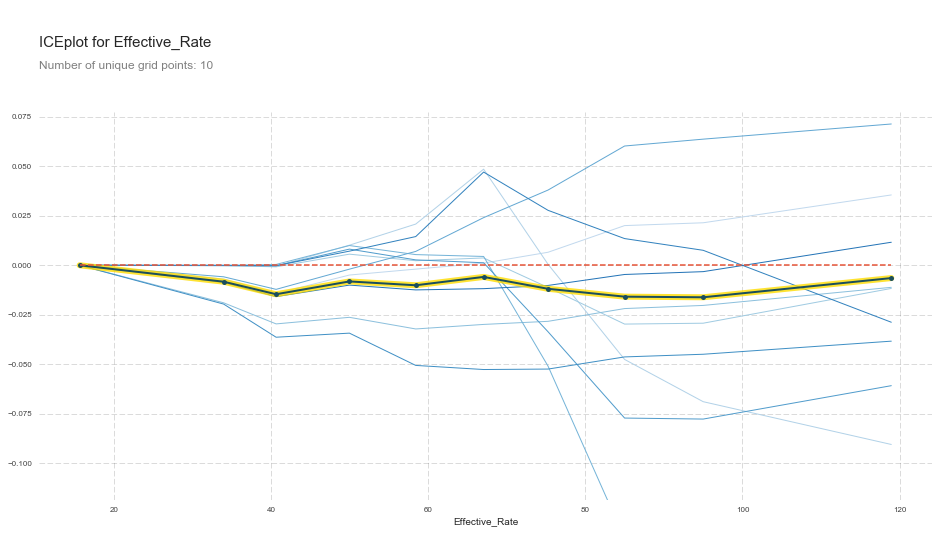

In [112]:
plot_pdp('Effective_Rate', clusters = 10)

**Summary**

These images leads me to believe along with a lot of research that:

The idea that money can't buy happiness has been disproved by science, at least up to a point. Experts say that happiness does increase with wealth, but the correlation peaks at earning $75,000 per year.

You can see that this is the case increasing your salary after 75 dollars an hour leads to a flatten and a slight increase in the chances you will leave the company. The more money you make the more responsibility you are going to be having. 

#### Distance From Home

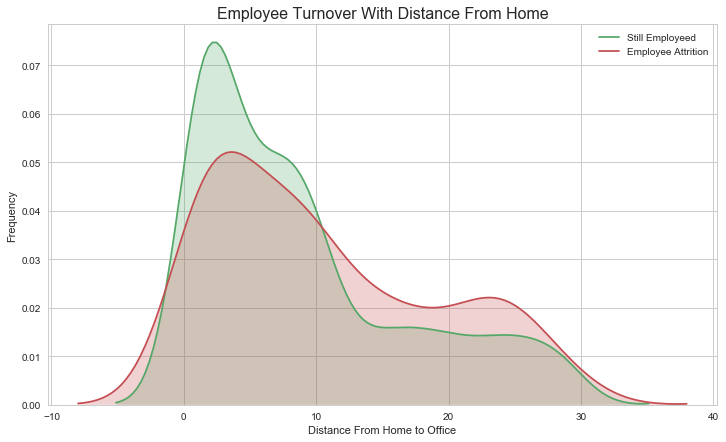

In [113]:
plt.figure(figsize=(12,7))
ax=sns.kdeplot(df_raw.loc[(df_raw.Attrition==0),'DistanceFromHome'],color="g",shade=True,label="Still Employeed")
ax=sns.kdeplot(df_raw.loc[(df_raw.Attrition==1),'DistanceFromHome'],color="r",shade=True,label="Employee Attrition")
ax.set(xlabel='Distance From Home to Office',ylabel="Frequency")
plt.title("Employee Turnover With Distance From Home",fontsize=16)

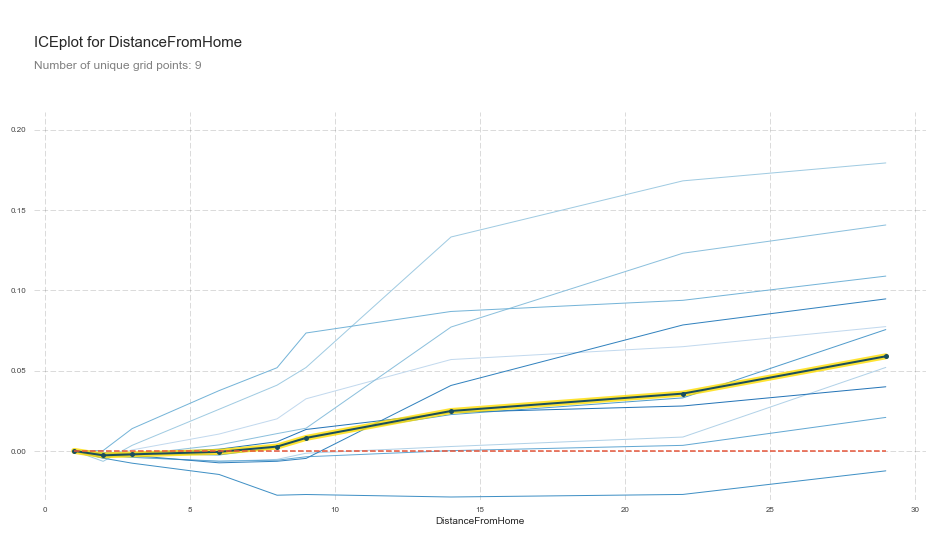

In [115]:
plot_pdp('DistanceFromHome', clusters = 10)

#### Total Working Years

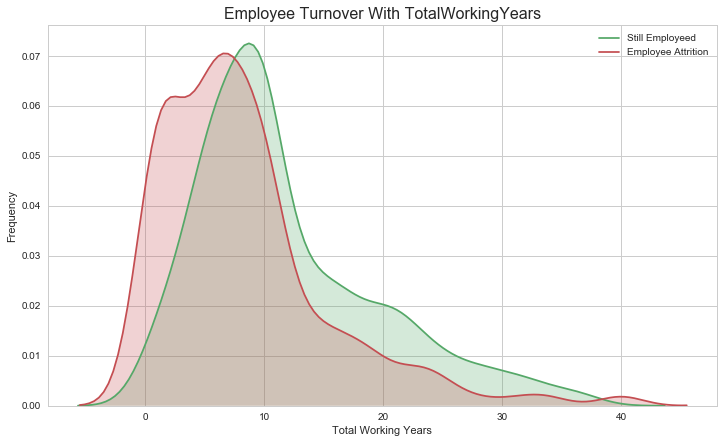

In [162]:
plt.figure(figsize=(12,7))
ax=sns.kdeplot(df_raw.loc[(df_raw.Attrition==0),'TotalWorkingYears'],color="g",shade=True,label="Still Employeed")
ax=sns.kdeplot(df_raw.loc[(df_raw.Attrition==1),'TotalWorkingYears'],color="r",shade=True,label="Employee Attrition")
ax.set(xlabel='Total Working Years',ylabel="Frequency")
plt.title("Employee Turnover With TotalWorkingYears",fontsize=16)

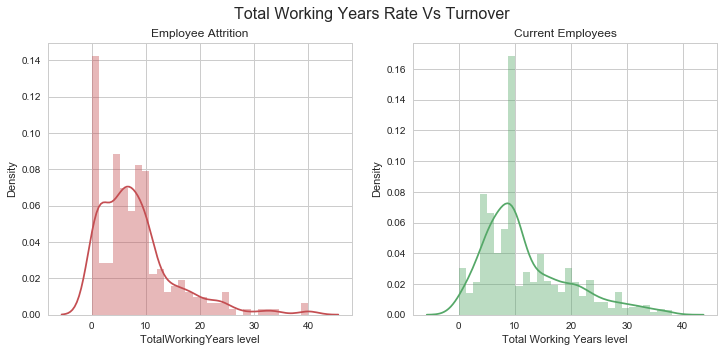

In [163]:
fig,ax=plt.subplots(ncols=2,figsize=(12,5))
left = df_raw[df_raw.Attrition == 1] 
stay = df_raw[df_raw.Attrition == 0]
sns.distplot(left.TotalWorkingYears, color = "r", bins = 30, ax=ax[0])
ax[0].set_xlabel("TotalWorkingYears level")
ax[0].set_ylabel("Density")
ax[0].set_title("Employee Attrition")
sns.distplot(stay.TotalWorkingYears,  color = "g", bins = 30, ax=ax[1])
ax[1].set_xlabel("Total Working Years level")
ax[1].set_ylabel("Density")
ax[1].set_title("Current Employees")
plt.suptitle("Total Working Years Rate Vs Turnover",fontsize=16)

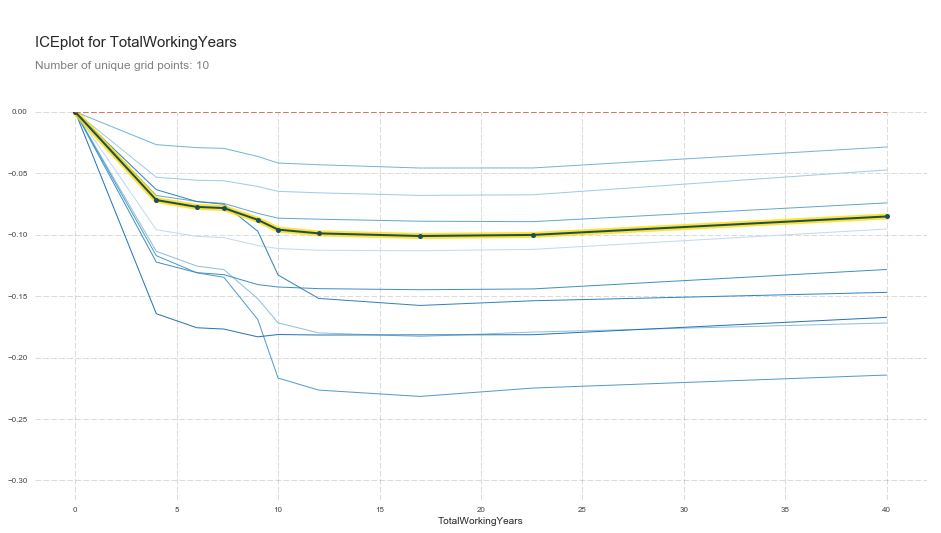

In [124]:
plot_pdp('TotalWorkingYears', clusters = 10)

#### Job Level

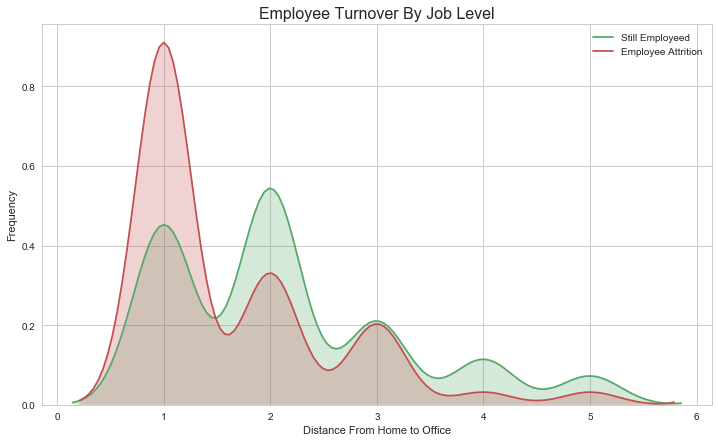

In [161]:
plt.figure(figsize=(12,7))
ax=sns.kdeplot(df_raw.loc[(df_raw.Attrition==0),'JobLevel'],color="g",shade=True,label="Still Employeed")
ax=sns.kdeplot(df_raw.loc[(df_raw.Attrition==1),'JobLevel'],color="r",shade=True,label="Employee Attrition")
ax.set(xlabel='Distance From Home to Office',ylabel="Frequency")
plt.title("Employee Turnover By Job Level",fontsize=16)

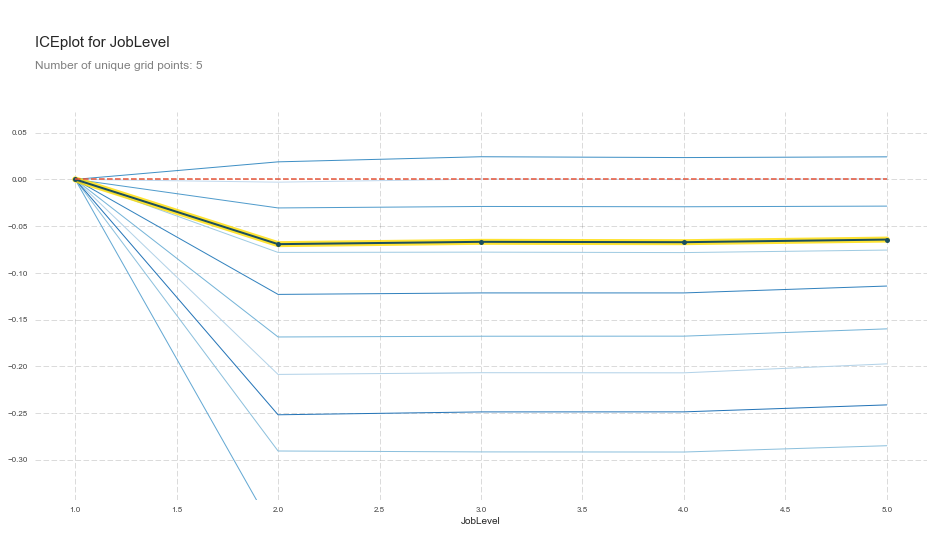

In [119]:
plot_pdp('JobLevel', clusters = 10)

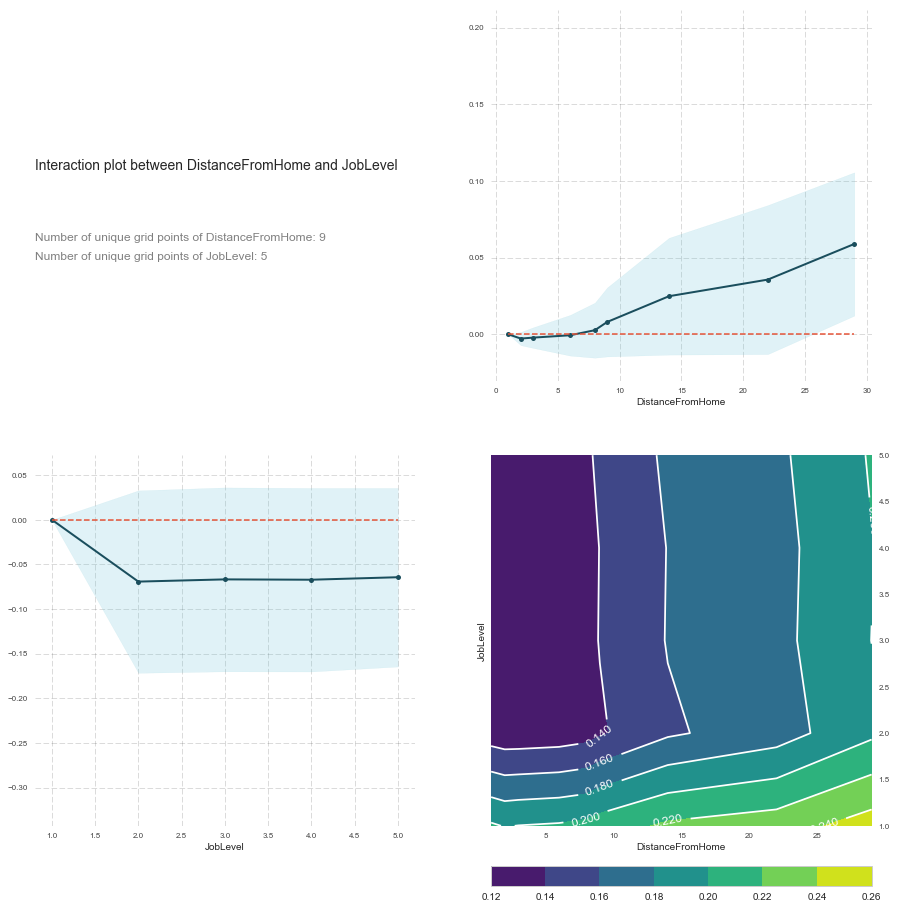

In [123]:
feats = ['DistanceFromHome', 'JobLevel']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)